# Divisão de um município em setores censitários e bairros

Itens a serem vistos:

- como baixar as malhas de outros estados do Brasil
- como baixar o arquivo com as variáveis divididas por setores censitários de MG
- plotar bairros de Varginha (divisão por setores)
- plotar nomes dos bairros de outros municípios de MG (Passos e BH)
- arquivo 'basico_MG.csv' do IBGE
- unir as informações geográficas dos setores de VGN com o 'basico_MG.csv'

### Setores censitários

Para baixar as malhas dos outros estados do Brasil ir em:

https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/setores_censitarios_shp/

Para baixar o arquivo com as variáveis por setores censitários em MG:

https://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Resultados_do_Universo/Agregados_por_Setores_Censitarios/

In [ ]:
!pip install geopandas shapely mapclassify libpysal splot esda pysal
!pip install --upgrade pyshp
!pip install --upgrade descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 15.7 MB/s 
     |████████████████████████████████| 2.4 MB 46.3 MB/s 
     |████████████████████████████████| 95 kB 4.4 MB/s 
     |████████████████████████████████| 16.7 MB 445 kB/s 
     |████████████████████████████████| 6.3 MB 32.9 MB/s 
     |████████████████████████████████| 209 kB 49.8 MB/s 
     |████████████████████████████████| 60 kB 7.6 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 46 kB 668 kB/s 
     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 147 kB 45.6 MB/s 
     |████████████████████████████████| 41 kB 448 kB/s 
     |████████████████████████████████| 243 kB 16.4 MB/s 
     |████████████████████████████████| 5.7 MB 44.7 MB/s 
     |████████████████████████████████| 179 kB 43.0 MB/s 
     |████████████████████████████████| 2.1

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as sm
import os

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# para a análise de dados espaciais
import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# links com arquivos úteis
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/'
link_p = 'https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/'

Baixei os dados de MG em:

https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/setores_censitarios_shp/

In [2]:
# estado de Minas Gerais dividido em setores censitários
# corrigir o caminho do arquivo no google drive
setores = gp.read_file('mg_setores_censitarios/31SEE250GC_SIR.shp')

In [3]:
# estado de Minas Gerais dividido em setores censitários
# se o shapefile for carregado diretamente no colab, usar esse comando

# setores = gp.read_file('31SEE250GC_SIR.shp')

In [4]:
setores.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry
0,1,310010405000011,RURAL,None,None,31001040500,None,310010405,ABADIA DOS DOURADOS,3100104,ABADIA DOS DOURADOS,PATROCÍNIO,TRIÂNGULO MINEIRO/ALTO PARANAÍBA,"POLYGON ((-47.57649 -18.22600, -47.57596 -18.2..."
1,2,310010405000012,RURAL,None,None,31001040500,None,310010405,ABADIA DOS DOURADOS,3100104,ABADIA DOS DOURADOS,PATROCÍNIO,TRIÂNGULO MINEIRO/ALTO PARANAÍBA,"POLYGON ((-47.42967 -18.16543, -47.42943 -18.1..."
2,3,310010405000013,RURAL,None,None,31001040500,None,310010405,ABADIA DOS DOURADOS,3100104,ABADIA DOS DOURADOS,PATROCÍNIO,TRIÂNGULO MINEIRO/ALTO PARANAÍBA,"POLYGON ((-47.42649 -18.29056, -47.42643 -18.2..."
3,4,310020305000001,URBANO,310020305013,Zona Central,31002030500,None,310020305,ABAETÉ,3100203,ABAETÉ,TRÊS MARIAS,CENTRAL MINEIRA,"POLYGON ((-45.44671 -19.15200, -45.44651 -19.1..."
4,5,310020305000002,URBANO,310020305006,Fátima,31002030500,None,310020305,ABAETÉ,3100203,ABAETÉ,TRÊS MARIAS,CENTRAL MINEIRA,"POLYGON ((-45.44291 -19.15714, -45.44275 -19.1..."


In [5]:
setores.NM_MESO.unique()

array(['TRIÂNGULO MINEIRO/ALTO PARANAÍBA', 'CENTRAL MINEIRA',
       'ZONA DA MATA', 'VALE DO RIO DOCE', 'OESTE DE MINAS',
       'VALE DO MUCURI', 'NORTE DE MINAS', 'SUL/SUDOESTE DE MINAS',
       'CAMPO DAS VERTENTES', 'JEQUITINHONHA',
       'METROPOLITANA DE BELO HORIZONTE', 'NOROESTE DE MINAS'],
      dtype=object)

In [6]:
setores.shape

(32807, 14)

In [7]:
# evitar problemas com nomes
setores = setores.to_crs(epsg=3395)

In [8]:
# a partir do shapefile de setores do estado, selecionar apenas uma mesorregião
meso = setores.query('NM_MESO == "SUL/SUDOESTE DE MINAS"')
meso.shape

(4339, 14)

In [9]:
meso.shape

(4339, 14)

Importante: os arquivos *shapefile* podem ser condensados para o formato json e podem ser salvos de forma que sejam usados depois. Para isso, basta usar as duas células abaixo (basta tirar o comentário do comando).

In [ ]:
# cria o arquivo .json na área de arquivos à esquerda e ele pode ser usado posteriormente
# setores.to_file('setores-mg.json', driver='GeoJSON')

In [ ]:
# cria outro arquivo .json na área de arquivos à esquerda
# meso.to_file('setores-sul-mg.json', driver='GeoJSON')

In [10]:
# a partir do shapefile de setores do estado, selecionar o município escolhido e apenas os setores urbanos
muni = setores.query('NM_MUNICIP == "VARGINHA"')
mapa_muni = muni.query('TIPO == "URBANO"')
mapa_muni.shape

(161, 14)

In [11]:
mapa_muni.columns

Index(['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODB', 'NM_BAIRRO', 'CD_GEOCODS',
       'NM_SUBDIST', 'CD_GEOCODD', 'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP',
       'NM_MICRO', 'NM_MESO', 'geometry'],
      dtype='object')

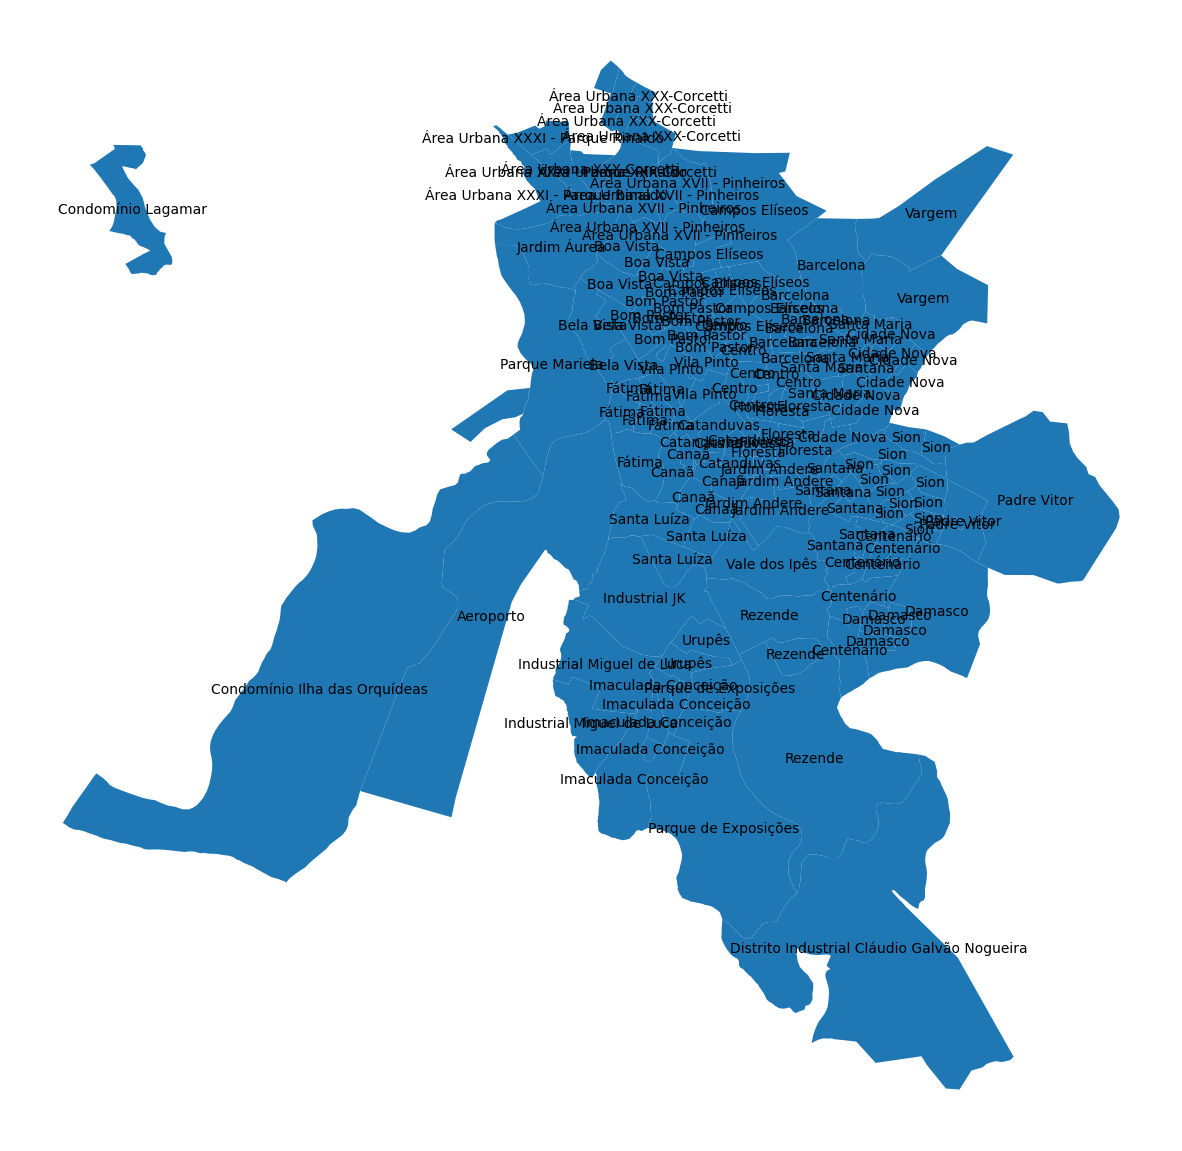

In [12]:
# plotar os bairros, porém, a divisão está em setores censitários
# (há bairros repetidos)
mapa = mapa_muni
ax = mapa.plot(figsize=(15,15))

for i in mapa.index:
    plt.text(mapa.geometry.centroid[i].coords[0][0], mapa.geometry.centroid[i].coords[0][1], mapa.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='center')

ax.set_axis_off();

In [13]:
# tentar agrupar em bairros
# mapa contém as informações divididas em setores censitários e queremos unir os setores em bairros
# uso da função dissolve
# http://geopandas.org/aggregation_with_dissolve.html
bairros = mapa_muni.dissolve(by='NM_BAIRRO')
bairros.head()

,geometry,ID,CD_GEOCODI,TIPO,CD_GEOCODB,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO
NM_BAIRRO,,,,,,,,,,,,,
Aeroporto,"POLYGON ((-5059936.746 -2443242.730, -5059916....",32221,317070105000120,URBANO,317070105030,31707010500,None,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS
Barcelona,"POLYGON ((-5056899.638 -2442204.154, -5056905....",32174,317070105000063,URBANO,317070105014,31707010500,None,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS
Bela Vista,"POLYGON ((-5059465.758 -2442533.790, -5059417....",32155,317070105000044,URBANO,317070105010,31707010500,None,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS
Boa Vista,"POLYGON ((-5059013.775 -2441188.083, -5058975....",32157,317070105000046,URBANO,317070105011,31707010500,None,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS
Bom Pastor,"POLYGON ((-5058433.824 -2442372.251, -5058474....",32160,317070105000049,URBANO,317070105012,31707010500,None,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS


In [14]:
# plotar os bairros usando o novo dataframe bairros
# Obs.: os índices ficaram como os nomes dos bairros, por isso, criei uma nova coluna NM_BAIRRO para
# colocar os nomes dos bairros e a nova coluna index irá de 0 a 37 (número de bairros)
bairros['NM_BAIRRO'] = bairros.index
bairros.index = range(len(bairros))
bairros.head()

,geometry,ID,CD_GEOCODI,TIPO,CD_GEOCODB,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,NM_BAIRRO
0,"POLYGON ((-5059936.746 -2443242.730, -5059916....",32221,317070105000120,URBANO,317070105030,31707010500,None,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,Aeroporto
1,"POLYGON ((-5056899.638 -2442204.154, -5056905....",32174,317070105000063,URBANO,317070105014,31707010500,None,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,Barcelona
2,"POLYGON ((-5059465.758 -2442533.790, -5059417....",32155,317070105000044,URBANO,317070105010,31707010500,None,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,Bela Vista
3,"POLYGON ((-5059013.775 -2441188.083, -5058975....",32157,317070105000046,URBANO,317070105011,31707010500,None,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,Boa Vista
4,"POLYGON ((-5058433.824 -2442372.251, -5058474....",32160,317070105000049,URBANO,317070105012,31707010500,None,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,Bom Pastor


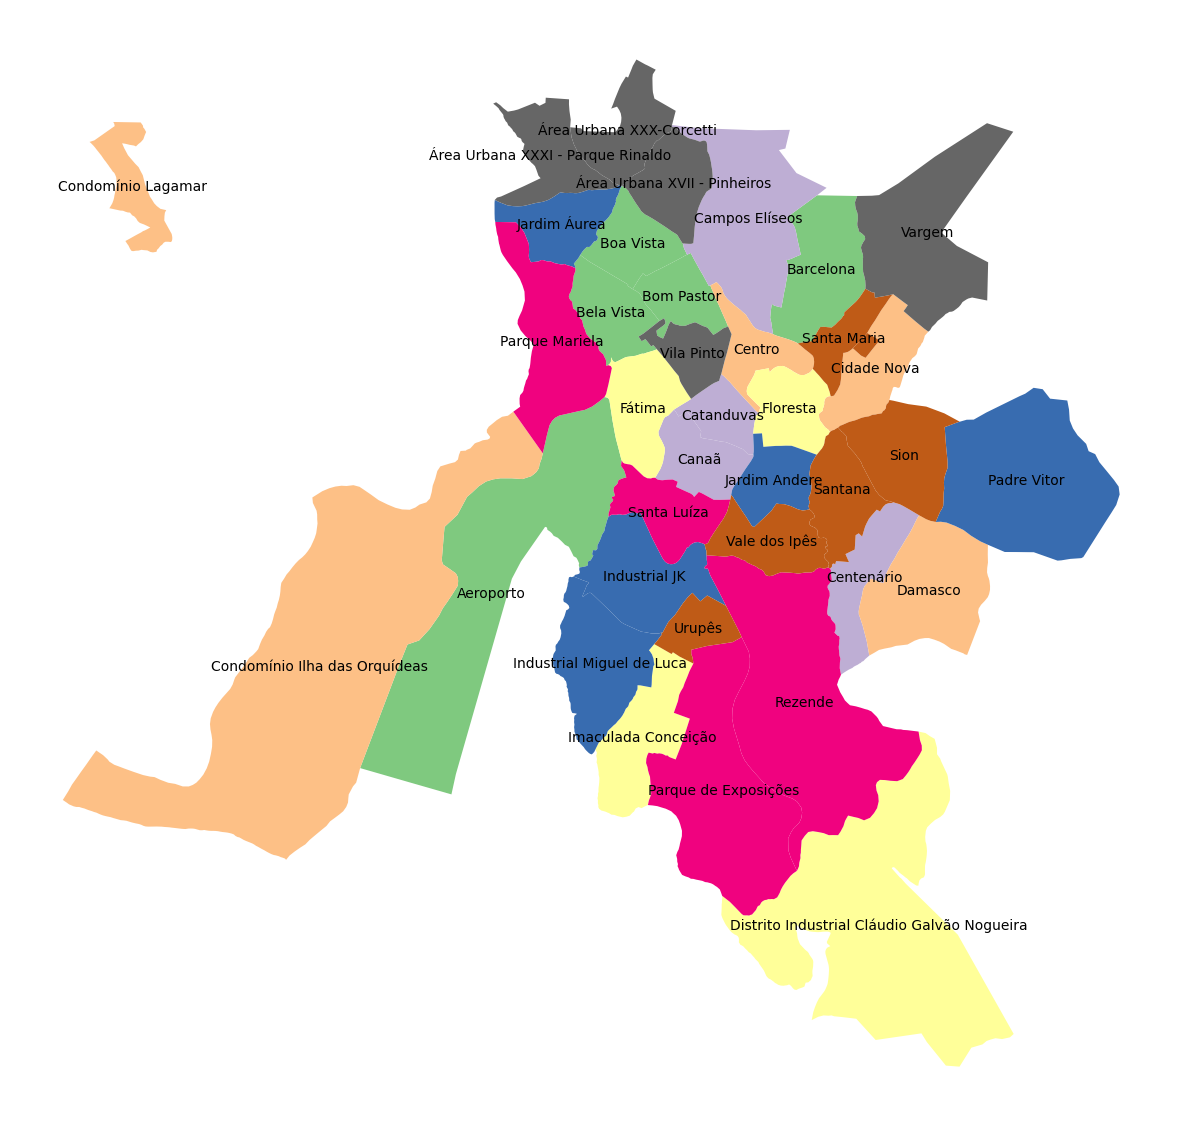

In [15]:
# plotar os bairros
ax = bairros.plot(figsize=(15,15), cmap='Accent')

for i in bairros.index:
    plt.text(bairros.geometry.centroid[i].coords[0][0], bairros.geometry.centroid[i].coords[0][1], bairros.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='center')

ax.set_axis_off();

## Plotar os nomes dos bairros de outro município de MG:

In [16]:
# para saber quais municípios possuem os nomes dos bairros disponíveis
setores.NM_BAIRRO.fillna('nnnn', inplace=True)  # preencher os que não têm nomes dos bairros com a string 'nnnn'
setores = setores.query('NM_BAIRRO != "nnnn"')

In [17]:
# retornar esses municípios
setores['NM_MUNICIP'].unique()

array(['ABAETÉ', 'BELO HORIZONTE', 'ARAXÁ', 'ARCOS', 'AREADO', 'BETIM',
       'BICAS', 'CARMO DO PARANAÍBA', 'CANÁPOLIS', 'CARANGOLA',
       'CARATINGA', 'CONCEIÇÃO DAS ALAGOAS', 'CORONEL FABRICIANO',
       'COROMANDEL', 'GOVERNADOR VALADARES', 'ITUIUTABA',
       'FREI INOCÊNCIO', 'IPATINGA', 'ITAÚNA', 'IPANEMA', 'ITABIRITO',
       'JUIZ DE FORA', 'JEQUITINHONHA', 'MANHUAÇU', 'MAR DE ESPANHA',
       'MONTE ALEGRE DE MINAS', 'NANUQUE', 'NOVA PONTE', 'PASSOS',
       'PIRAPORA', 'POÇOS DE CALDAS', 'PATOS DE MINAS', 'PATROCÍNIO',
       'PEÇANHA', 'PONTE NOVA', 'SACRAMENTO', 'RESPLENDOR', 'SÃO GOTARDO',
       'SANTA JULIANA', 'SÃO GERALDO DO BAIXIO', 'SÃO JOÃO DEL REI',
       'SÃO ROMÃO', 'TUPACIGUARA', 'UBERLÂNDIA', 'VARGINHA',
       'MATHIAS LOBATO', 'SOBRÁLIA', 'TEÓFILO OTONI', 'TIMÓTEO',
       'VESPASIANO'], dtype=object)

Município escolhido: Passos

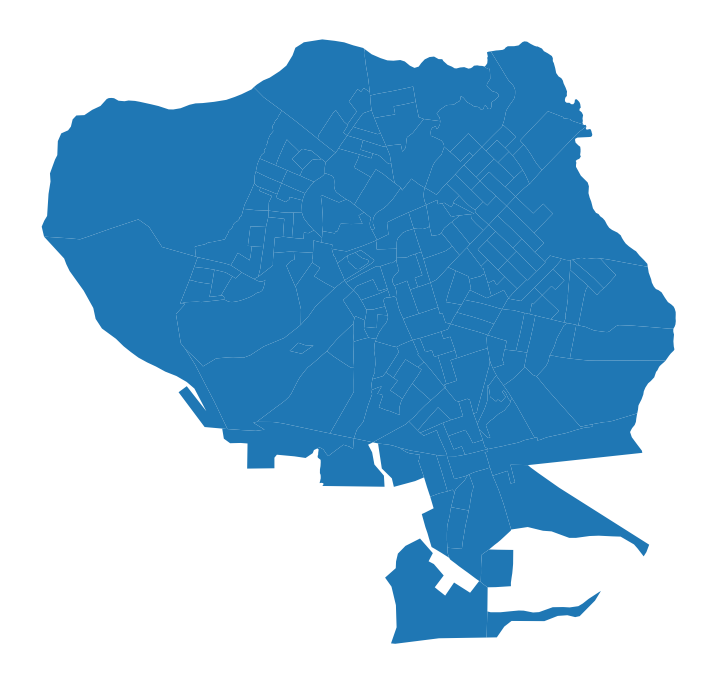

In [18]:
# plotar o mapa sem os nomes
munic = setores.query('NM_MUNICIP == "PASSOS"')
mapa_munic = munic.query('TIPO == "URBANO"')
mapa_munic.plot(figsize=(9,9)).set_axis_off();

In [19]:
# verificar se existem bairros para o município escolhido
# dataframe.NM_BAIRRO
munic.NM_BAIRRO

22827                     Centro
22828                     Centro
22829                     Centro
22830                     Centro
22831                     Centro
                  ...           
23087              João Paulo II
23088                  Aclimação
23089                  Aclimação
23090    Nossa Senhora Aparecida
23096                Polivalente
Name: NM_BAIRRO, Length: 169, dtype: object

In [20]:
mapa_munic.columns

Index(['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODB', 'NM_BAIRRO', 'CD_GEOCODS',
       'NM_SUBDIST', 'CD_GEOCODD', 'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP',
       'NM_MICRO', 'NM_MESO', 'geometry'],
      dtype='object')

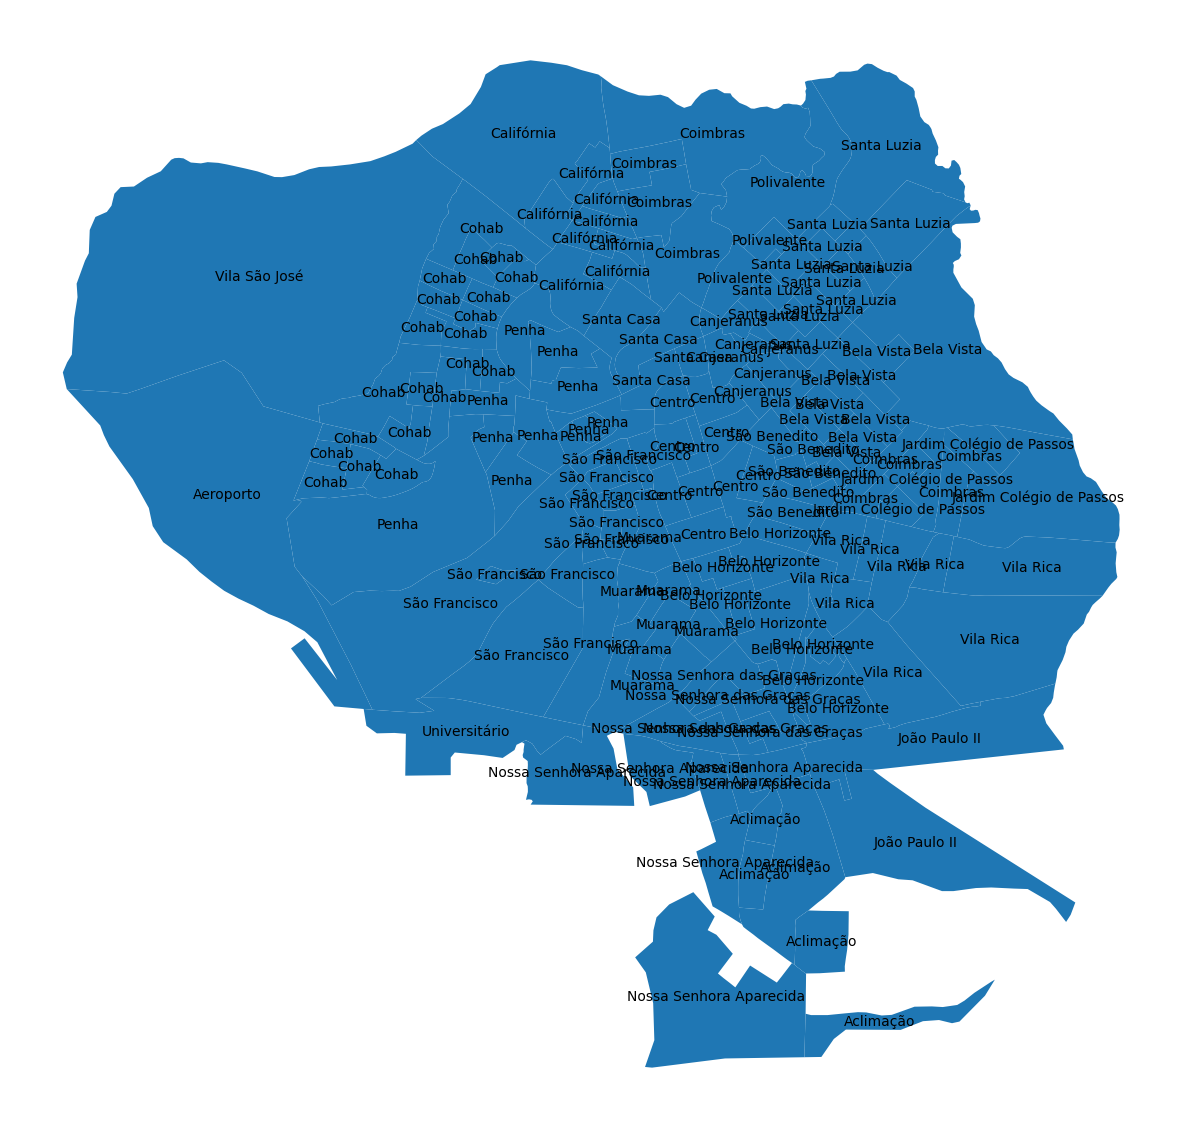

In [21]:
# plotar os bairros, porém, a divisão está em setores censitários
# (há bairros repetidos)
mapa = mapa_munic
ax = mapa.plot(figsize=(15,15))

for i in mapa.index:
    plt.text(mapa.geometry.centroid[i].coords[0][0], mapa.geometry.centroid[i].coords[0][1], mapa.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='center')

ax.set_axis_off();

In [22]:
# tentar agrupar em bairros
bairros = mapa_munic.dissolve(by='NM_BAIRRO')
bairros.head()

,geometry,ID,CD_GEOCODI,TIPO,CD_GEOCODB,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO
NM_BAIRRO,,,,,,,,,,,,,
Aclimação,"MULTIPOLYGON (((-5186163.375 -2347922.848, -51...",22936,314790705000109,URBANO,314790705021,31479070500,None,314790705,PASSOS,3147907,PASSOS,PASSOS,SUL/SUDOESTE DE MINAS
Aeroporto,"POLYGON ((-5193878.698 -2342825.877, -5193508....",22884,314790705000057,URBANO,314790705011,31479070500,None,314790705,PASSOS,3147907,PASSOS,PASSOS,SUL/SUDOESTE DE MINAS
Bela Vista,"POLYGON ((-5187325.994 -2343483.880, -5187379....",22916,314790705000089,URBANO,314790705018,31479070500,None,314790705,PASSOS,3147907,PASSOS,PASSOS,SUL/SUDOESTE DE MINAS
Belo Horizonte,"POLYGON ((-5187104.885 -2345665.158, -5187134....",22866,314790705000039,URBANO,314790705007,31479070500,None,314790705,PASSOS,3147907,PASSOS,PASSOS,SUL/SUDOESTE DE MINAS
Califórnia,"POLYGON ((-5188998.706 -2341915.811, -5188990....",22895,314790705000068,URBANO,314790705014,31479070500,None,314790705,PASSOS,3147907,PASSOS,PASSOS,SUL/SUDOESTE DE MINAS


In [23]:
# plotar os bairros usando o novo dataframe bairros
# Obs.: os índices ficaram como os nomes dos bairros, por isso, criei uma nova coluna NM_BAIRRO para
# colocar os nomes dos bairros e a nova coluna index irá de 0 a 37 (número de bairros)
bairros['NM_BAIRRO'] = bairros.index
bairros.index = range(len(bairros))
bairros.head()

,geometry,ID,CD_GEOCODI,TIPO,CD_GEOCODB,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,NM_BAIRRO
0,"MULTIPOLYGON (((-5186163.375 -2347922.848, -51...",22936,314790705000109,URBANO,314790705021,31479070500,None,314790705,PASSOS,3147907,PASSOS,PASSOS,SUL/SUDOESTE DE MINAS,Aclimação
1,"POLYGON ((-5193878.698 -2342825.877, -5193508....",22884,314790705000057,URBANO,314790705011,31479070500,None,314790705,PASSOS,3147907,PASSOS,PASSOS,SUL/SUDOESTE DE MINAS,Aeroporto
2,"POLYGON ((-5187325.994 -2343483.880, -5187379....",22916,314790705000089,URBANO,314790705018,31479070500,None,314790705,PASSOS,3147907,PASSOS,PASSOS,SUL/SUDOESTE DE MINAS,Bela Vista
3,"POLYGON ((-5187104.885 -2345665.158, -5187134....",22866,314790705000039,URBANO,314790705007,31479070500,None,314790705,PASSOS,3147907,PASSOS,PASSOS,SUL/SUDOESTE DE MINAS,Belo Horizonte
4,"POLYGON ((-5188998.706 -2341915.811, -5188990....",22895,314790705000068,URBANO,314790705014,31479070500,None,314790705,PASSOS,3147907,PASSOS,PASSOS,SUL/SUDOESTE DE MINAS,Califórnia


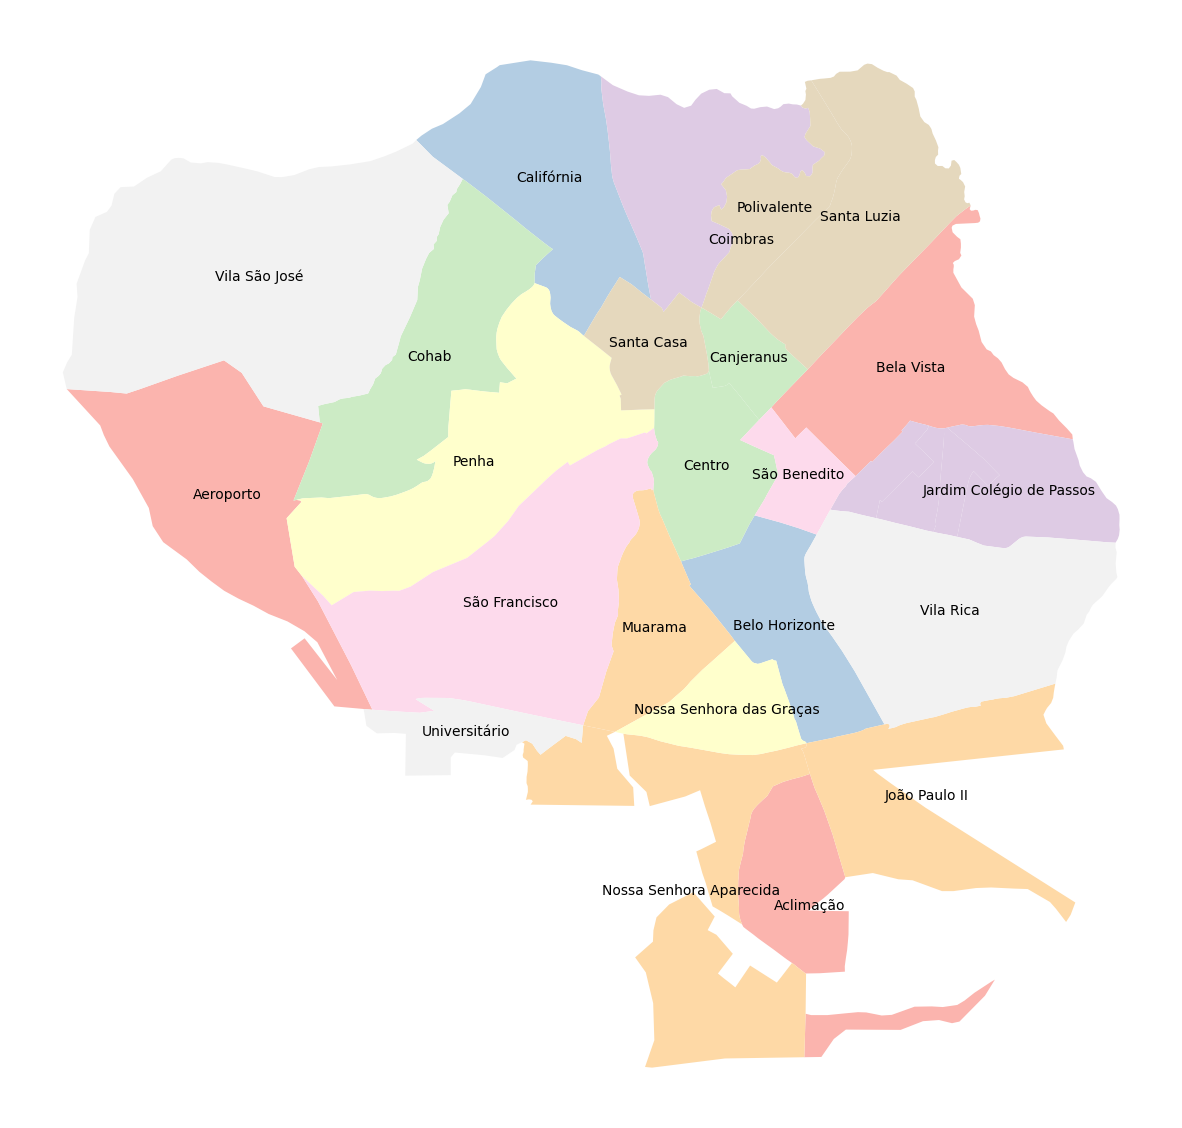

In [24]:
# plotar os bairros
ax = bairros.plot(figsize=(15,15), cmap='Pastel1')

for i in bairros.index:
    plt.text(bairros.geometry.centroid[i].coords[0][0], bairros.geometry.centroid[i].coords[0][1], bairros.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='center')

ax.set_axis_off();

**Tarefa:**

Escolher outro município que possua informações sobre os bairros no sul de MG e plotar os bairros, como eu fiz para Varginha e Passos.


## Belo Horizonte

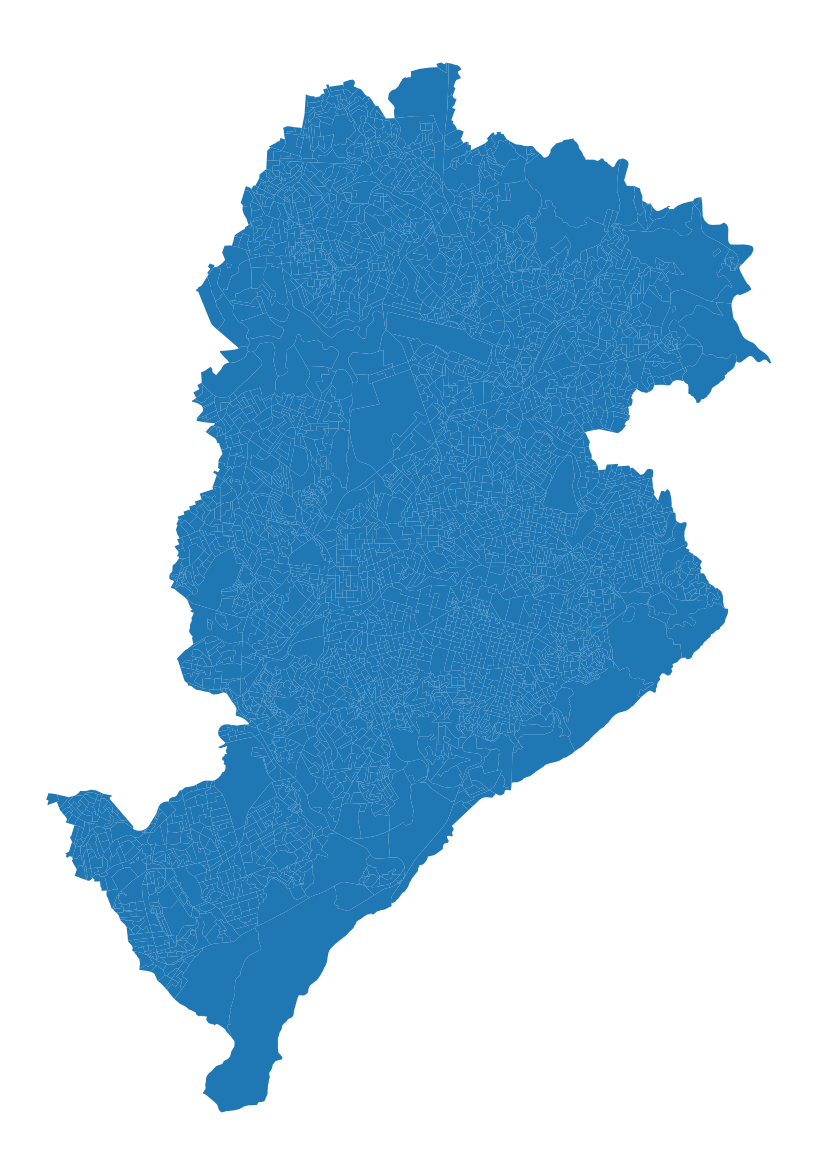

In [25]:
# plotar o mapa sem os nomes
bh = setores.query('NM_MUNICIP == "BELO HORIZONTE"')
mapa_bh = bh.query('TIPO == "URBANO"')
mapa_bh.plot(figsize=(15,15)).set_axis_off();

In [26]:
bh.NM_BAIRRO

732                  Boa Viagem
733                      Centro
734                    Floresta
735                    Floresta
736                    Floresta
                 ...           
6008                 Copacabana
6009              Jardim Leblon
6010                     Europa
6011              Jardim Leblon
6012    Jardim dos Comerciarios
Name: NM_BAIRRO, Length: 3936, dtype: object

In [27]:
mapa_bh.columns

Index(['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODB', 'NM_BAIRRO', 'CD_GEOCODS',
       'NM_SUBDIST', 'CD_GEOCODD', 'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP',
       'NM_MICRO', 'NM_MESO', 'geometry'],
      dtype='object')

In [28]:
mapa = mapa_bh

In [29]:
# tentar agrupar em bairros
bairros = mapa_bh.dissolve(by='NM_BAIRRO')
bairros.head()

,geometry,ID,CD_GEOCODI,TIPO,CD_GEOCODB,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO
NM_BAIRRO,,,,,,,,,,,,,
Aarão Reis,"POLYGON ((-4888947.600 -2240561.458, -4888995....",5216,310620060660092,URBANO,310620060422,31062006066,NORTE,310620060,VENDA NOVA,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE
Acaba Mundo,"POLYGON ((-4890116.960 -2253692.022, -4890080....",2170,310620005620143,URBANO,310620005103,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE
Acaiaca,"POLYGON ((-4886215.214 -2240483.156, -4886252....",4923,310620060640007,URBANO,310620060404,31062006064,NORDESTE,310620060,VENDA NOVA,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE
Ademar Maldonado,"POLYGON ((-4900768.441 -2256525.126, -4900824....",4577,310620025610098,URBANO,310620025358,31062002561,BARREIRO,310620025,BARREIRO,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE
Aeroporto,"POLYGON ((-4893228.173 -2241596.708, -4893257....",4252,310620005680046,URBANO,310620005257,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE


In [30]:
# plotar os bairros usando o novo dataframe bairros
# Obs.: os índices ficaram como os nomes dos bairros, por isso, criei uma nova coluna NM_BAIRRO para
# colocar os nomes dos bairros e a nova coluna index irá de 0 a 37 (número de bairros)
bairros['NM_BAIRRO'] = bairros.index
bairros.index = range(len(bairros))
bairros.head()

,geometry,ID,CD_GEOCODI,TIPO,CD_GEOCODB,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,NM_BAIRRO
0,"POLYGON ((-4888947.600 -2240561.458, -4888995....",5216,310620060660092,URBANO,310620060422,31062006066,NORTE,310620060,VENDA NOVA,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,Aarão Reis
1,"POLYGON ((-4890116.960 -2253692.022, -4890080....",2170,310620005620143,URBANO,310620005103,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,Acaba Mundo
2,"POLYGON ((-4886215.214 -2240483.156, -4886252....",4923,310620060640007,URBANO,310620060404,31062006064,NORDESTE,310620060,VENDA NOVA,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,Acaiaca
3,"POLYGON ((-4900768.441 -2256525.126, -4900824....",4577,310620025610098,URBANO,310620025358,31062002561,BARREIRO,310620025,BARREIRO,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,Ademar Maldonado
4,"POLYGON ((-4893228.173 -2241596.708, -4893257....",4252,310620005680046,URBANO,310620005257,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,Aeroporto


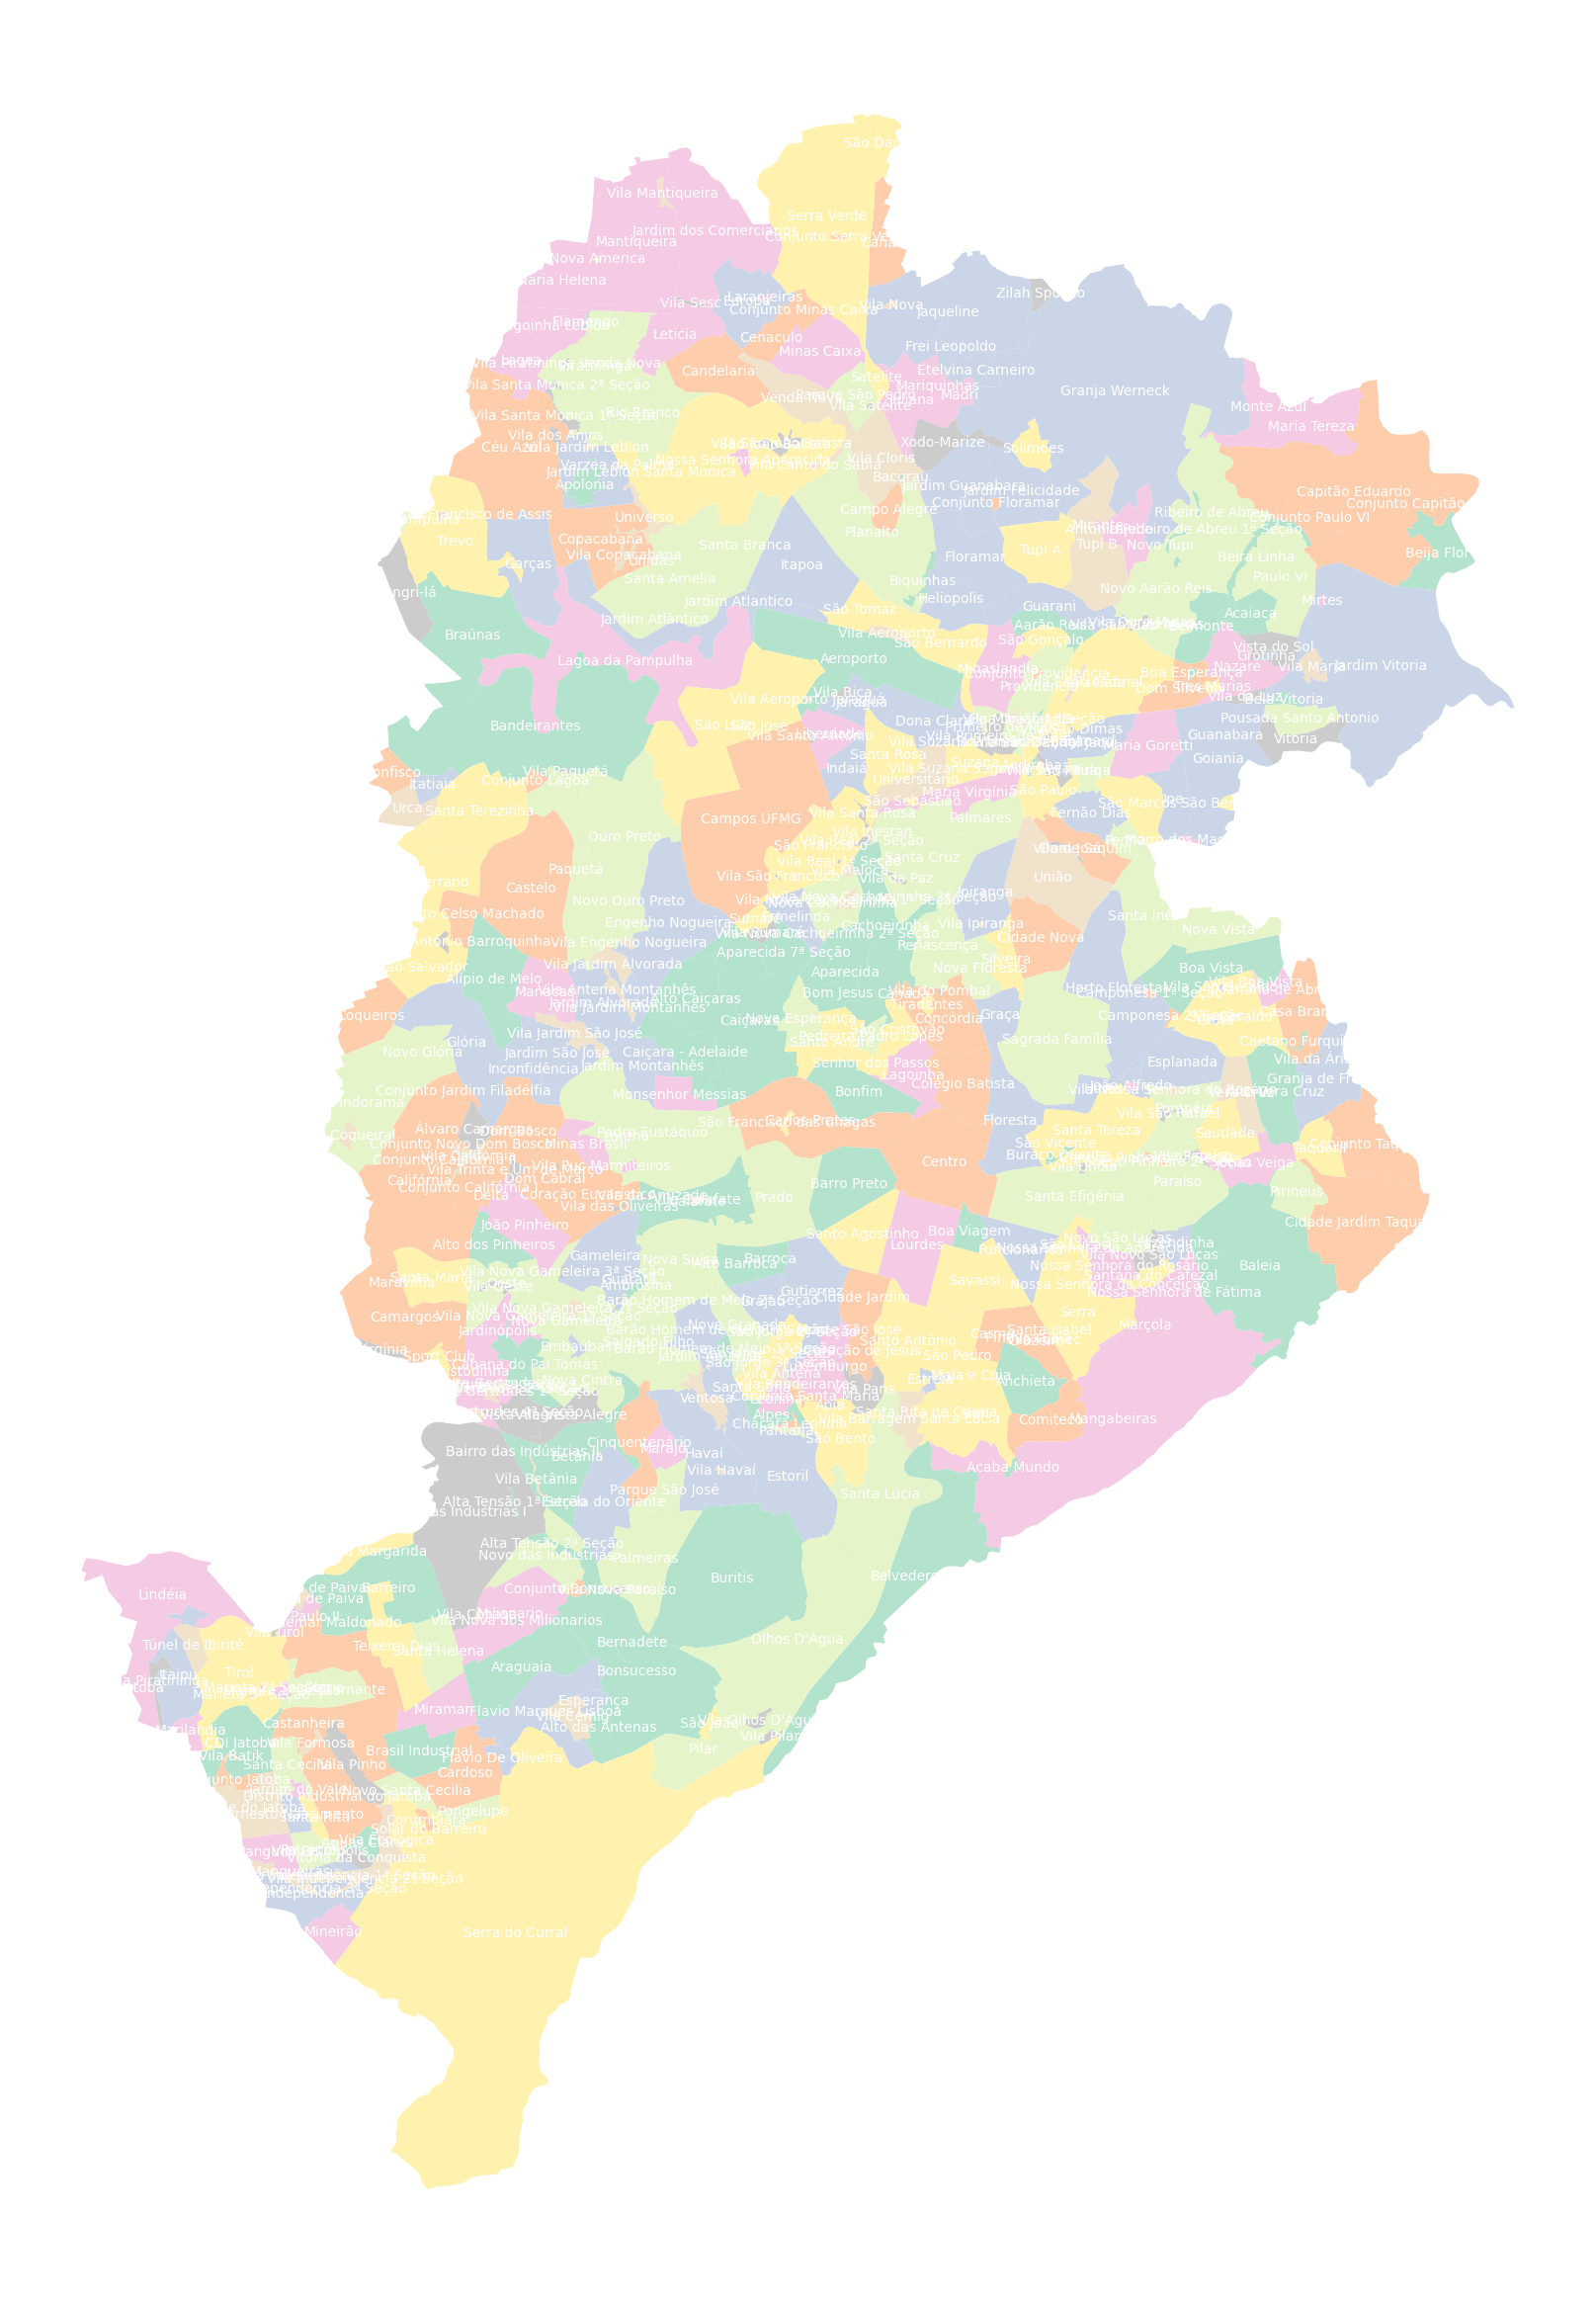

In [31]:
# plotar os bairros
ax = bairros.plot(figsize=(30,30), cmap='Pastel2')

for i in bairros.index:
    plt.text(bairros.geometry.centroid[i].coords[0][0], bairros.geometry.centroid[i].coords[0][1], bairros.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='center', fontdict={'color':'white'})

ax.set_axis_off();

### Unir com informações adicionais

O arquivo que usaremos será o 'basico_MG.csv'

As variáveis desse arquivo estão codificadas, para saber o que significam, consultar o arquivo 'base_setores_censitarios_censo_2010.pdf'

In [32]:
# carregar arquivo com dados sobre os setores censitários de MG
estado = pd.read_csv('mg_setores_censitarios/Basico_MG.csv', encoding='latin1', sep=';', decimal=',')
estado.head()

FileNotFoundError: [Errno 2] No such file or directory: 'mg_setores_censitarios/Basico_MG.csv'

In [33]:
estado.columns

NameError: name 'estado' is not defined

In [34]:
estado.Nome_do_municipio.unique()

NameError: name 'estado' is not defined

In [ ]:
# salvar as informações de Varginha num dataframe
muni_df = estado.query('Nome_do_municipio == "VARGINHA"')
muni_df = muni_df.query('Situacao_setor == [1, 2, 3]')   # só setores urbanos
muni_df.head()

In [ ]:
muni_df.shape    # setores censitários

In [ ]:
muni_df.columns   # variáveis

In [ ]:
# vamos incluir as informações das variáveis presentes em 'muni_df'
# e chamar o dataframe de geodf
# como usaremos a coluna de código do setor censitário como a variável para unir os dois conjuntos de
# dados, o nome dessa coluna deve ser o mesmo nos dois (chamarei de 'Cod_setor')
df = muni_df
geodf = mapa_muni
geodf.geometry = geodf.geometry.simplify(0.001)
geodf.rename(columns={'CD_GEOCODI': 'CD_setor'}, inplace=True)
geodf.head()

In [ ]:
geodf.shape

In [ ]:
# os códigos não estão sendo lidos como inteiros, transformá-los em inteiros
geodf.CD_setor = geodf.CD_setor.astype('int64')

In [ ]:
# para que os dois dataframes tenham a coluna de códigos com o mesmo nome,
# alterar para CD_setor
df.rename(columns={'Cod_setor': 'CD_setor'}, inplace=True)

In [ ]:
# unir o dataframe de informações geográficas com o outro dataframe com as variáveis
# Obs.: 'suffixes' é para o caso de haver variáveis de mesmo nome, incluir alguma coisa no final do nome
# em cada dataframe
municipio = pd.merge(geodf, df, on='CD_setor')
municipio

In [ ]:
municipio.columns

In [ ]:
municipio.plot();

Mapa temático:

Olhando a Base de Informações por Setor Censitário, escolhi a variável V005
Valor do rendimento nominal médio mensal das pessoas responsáveis por domicílios
particulares permanentes (com e sem rendimento)

In [ ]:
municipio.plot(column='V005', figsize=(15, 13), scheme='quantiles', legend=True, k=4, cmap='Oranges');

In [ ]:
municipio.columns

In [ ]:
variavel = 'V005'

In [ ]:
# agrupar em bairros
bairros = municipio.dissolve(by='NM_BAIRRO')
# plotar os bairros usando o novo dataframe bairros
bairros['NM_BAIRRO'] = bairros.index
bairros.index = range(len(bairros))

In [ ]:
ax = bairros.plot(variavel, cmap='YlOrBr', edgecolor='lightgray', linewidth=0.4, alpha=.5, figsize=(15,15), scheme='quantiles', k=4, legend=True)

fontdict = dict(color='black', size=7)

for i in bairros.index:
    plt.text(bairros.geometry.centroid[i].coords[0][0], bairros.geometry.centroid[i].coords[0][1], bairros.Nome_do_bairro[i],
             fontdict=fontdict, horizontalalignment='center', verticalalignment='center')

plt.axis('equal')
ax.set_axis_off();

Qual a conclusão? Quais os bairros de renda mais alta e mais baixa do município? Quais as faixas de valores?